# Intel Image Classification Using PyTorch

## Introduction

In this project, I'm building an image classification model using PyTorch. The goal is to teach the model to correctly identify images into one of six categories: buildings, forest, glacier, mountain, sea, and street. I’m using the Intel Image Classification Dataset, which I found on Kaggle. Thw dataset is diverse, with around 25,000 images of natural scenes from all over the world, each image being 150x150 pixels.

To get the job done, I’ll be using Convolutional Neural Networks (CNNs). CNNs are great for this kind of task because they’re specifically designed to work well with visual data like images. They work similarly to regular neural networks, but with an added feature called convolution layers, which help in picking out patterns in images. By using CNNs, the aim is to achieve high accuracy in classifying these images into their correct categories.

## Content

1. Data Preparation and importing libraries
2. Data Augmentation and Loading
3. Exploratory Data Analysis
4. Model Development using Custom CNN
5. Model Summary and architecture
6. Initial Model Training and Validation
7. Initial Model Evaluation
8. Hyperparameter Tuning
9. Model Retraining with Hyperparameters
10. Final Model Evaluation
11. Visualization of model results
12. Model Saving and Loading

## 1. Data Preparation and importing libraries

Start by downloading and extracting the dataset from Kaggle, to do this you need to authenticate to kaggle api, steps for the authentication are [here](https://www.kaggle.com/docs/api)


In [1]:
# importing libraries
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import requests
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from PIL import Image
from torchsummary import summary
from kaggle.api.kaggle_api_extended import KaggleApi
from io import BytesIO
import optuna

# Set up Logging
logging.basicConfig(filename='application.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')


# Download and extract the dataset
def download_data(dataset_path):
    logging.info('Starting download of dataset')
    api = KaggleApi()
    api.authenticate()

    api.dataset_download_files('puneet6060/intel-image-classification', path=dataset_path, unzip=False)

    with zipfile.ZipFile(os.path.join(dataset_path, 'intel-image-classification.zip'), 'r') as zip_ref:
        zip_ref.extractall(dataset_path)

    os.remove(os.path.join(dataset_path, 'intel-image-classification.zip'))
    logging.info('Download completed successfully')

dataset_url = 'https://www.kaggle.com/puneet6060/intel-image-classification'
dataset_path = 'intel-image-classification'
# download_data(dataset_path)


## 2. Data Augmentation and Loading

To improve the model's generalization capabilities, we will apply various data augmentation techniques. Image data augmentation is used to expand the training dataset in order to improve the performance and ability of the model to generalize. When we work with image data there are cases where we've lack training dataset. Augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images. A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (Or a combination of the above). We'll also split the dataset into training, validation, and testing sets.


In [2]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=os.path.join(dataset_path, 'seg_train/seg_train'), transform=transform_train)
test_dataset = ImageFolder(root=os.path.join(dataset_path, 'seg_test/seg_test'), transform=transform_test)

# Split the training set into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
logging.info('Data loaders created, loading completed successfully')

## 3. Exploratory Data Analysis (EDA)

Before diving into building the model, it’s important to get a good feel for the dataset. We’ll start by looking at some sample images to see what we’re working with. Then, we’ll check out how the images are spread across the six categories to make sure there’s a good balance. We’ll also take a closer look at the sizes of the images and how their pixel values are distributed, which will help us understand any preprocessing that might be needed. This step is all about getting to know the data so we can make better decisions later on.


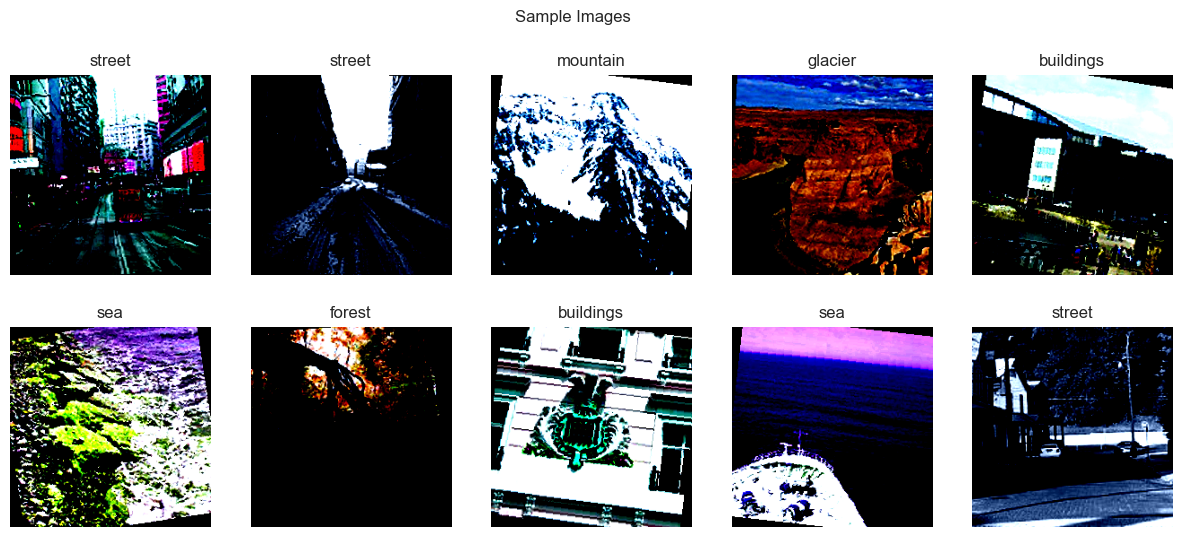

In [3]:
# EDA: Visualize sample images
logging.info('Performing EDA')

def visualize_data(dataset, classes):
    # Visualize sample images only
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Sample Images')
    for i, ax in enumerate(axes.flatten()):
        img, label = dataset[i]
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(classes[label])
        ax.axis('off')
    plt.show()

visualize_data(train_dataset, train_dataset.dataset.classes)
logging.info('EDA completed')

## 4. Model Development using Custom CNN

We will define a custom CNN model for the image classification task.


In [7]:
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # First convolutional layer
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second convolutional layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third convolutional layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth convolutional layer:
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 14 * 14, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(512, 6)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CustomCNN()

# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
logging.info('Model initialized successfully')

## 5.  Model Summary and architecture


The CNN model starts with an input layer of size \(3 \times 224 \times 224\) (for RGB images). This is followed by four convolutional blocks: the first block uses 64 filters, the second 128 filters, the third 256 filters, and the fourth 512 filters, each with ReLU activation and 2x2 max pooling. The output from these convolutional layers is then flattened into a 1D vector, which is passed through two fully connected layers with 1024 and 512 units, respectively, both using ReLU activation and 50% dropout. Finally, the model outputs class scores through a fully connected layer with 6 units, corresponding to the six classes in the classification task.

In [8]:
model = model.to('cuda')
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
         MaxPool2d-9          [-1, 256, 28, 28]               0
           Conv2d-10          [-1, 512, 28, 28]       1,180,160
             ReLU-11          [-1, 512, 28, 28]               0
        MaxPool2d-12          [-1, 512, 14, 14]               0
           Linear-13                 [-1, 1024]     102,761,472
             ReLU-14                 [-

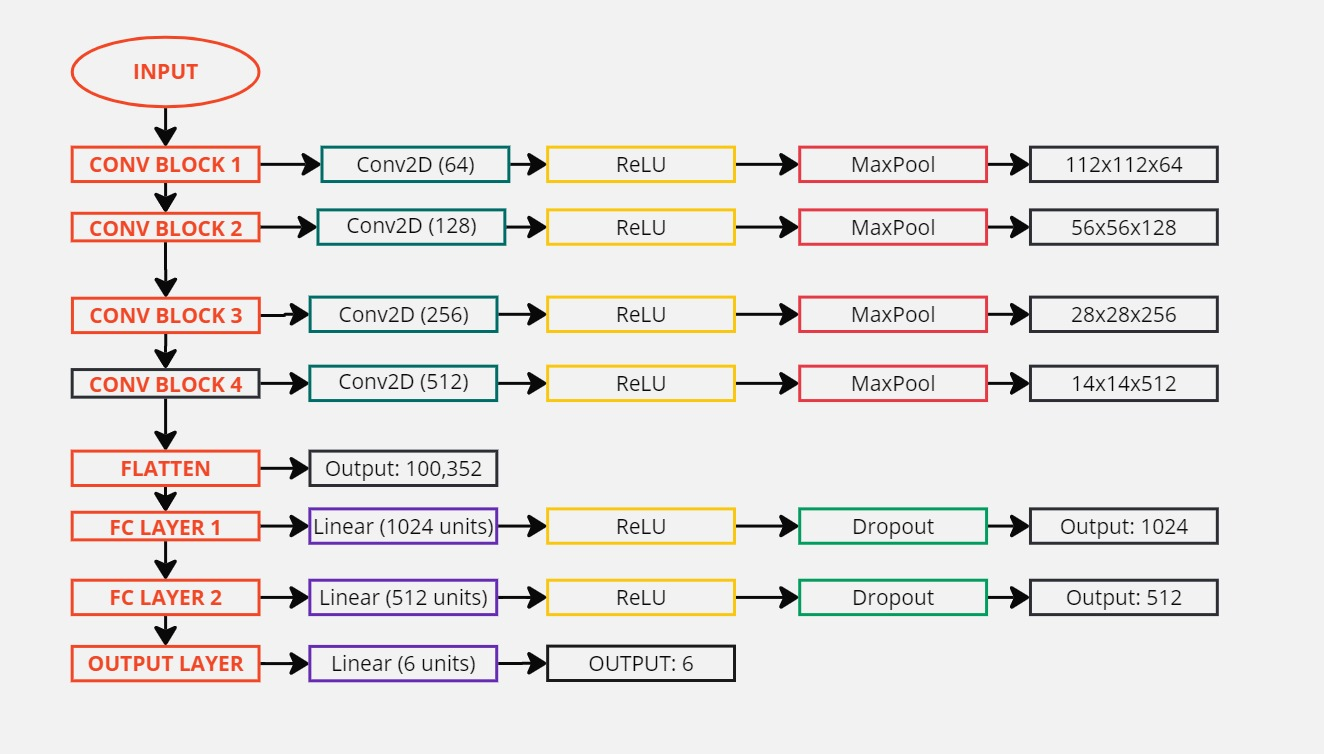

In [2]:
from IPython.display import Image, display
display(Image(filename='model_architecture/cnn_model_architecture.jpg'))

## 6. Initial Model Training and Validation

We will train the model and validate it using the validation set. We will also save the best model based on the validation loss.


Epoch 1/10, Train Loss: 1.1805, Val Loss: 0.8730
Epoch 2/10, Train Loss: 0.8794, Val Loss: 0.7180
Epoch 3/10, Train Loss: 0.7278, Val Loss: 0.6016
Epoch 4/10, Train Loss: 0.6460, Val Loss: 0.5418
Epoch 5/10, Train Loss: 0.5960, Val Loss: 0.5654
Epoch 6/10, Train Loss: 0.5559, Val Loss: 0.4950
Epoch 7/10, Train Loss: 0.5386, Val Loss: 0.5768
Epoch 8/10, Train Loss: 0.5210, Val Loss: 0.4889
Epoch 9/10, Train Loss: 0.4874, Val Loss: 0.4624
Epoch 10/10, Train Loss: 0.4743, Val Loss: 0.4894


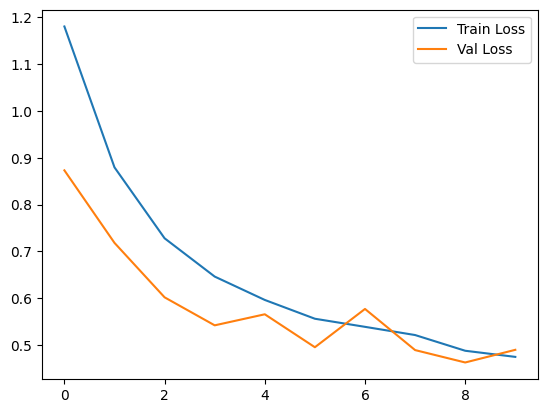

In [9]:
import torch

# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

# Train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    logging.info(f'Starting model training for {model.__class__.__name__}')
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        logging.info(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save(model.state_dict(), f'best_{model.__class__.__name__}.pth')
            logging.info(f'Best model saved for {model.__class__.__name__}')

    logging.info(f'Model training completed for {model.__class__.__name__}')
    return train_losses, val_losses

# Train the model and plot training and validation losses
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

# Load the best model
model.load_state_dict(torch.load(f'best_{model.__class__.__name__}.pth'))
logging.info('Best model loaded')

## 7. Initial Model Evaluation (on the Test dataset)

We will evaluate the model on the test set and calculate various metrics such as accuracy, precision, recall, and F1 score. We will also plot the confusion matrix and ROC curves.


Accuracy: 0.8347, Precision: 0.8360, Recall: 0.8347, F1 Score: 0.8344


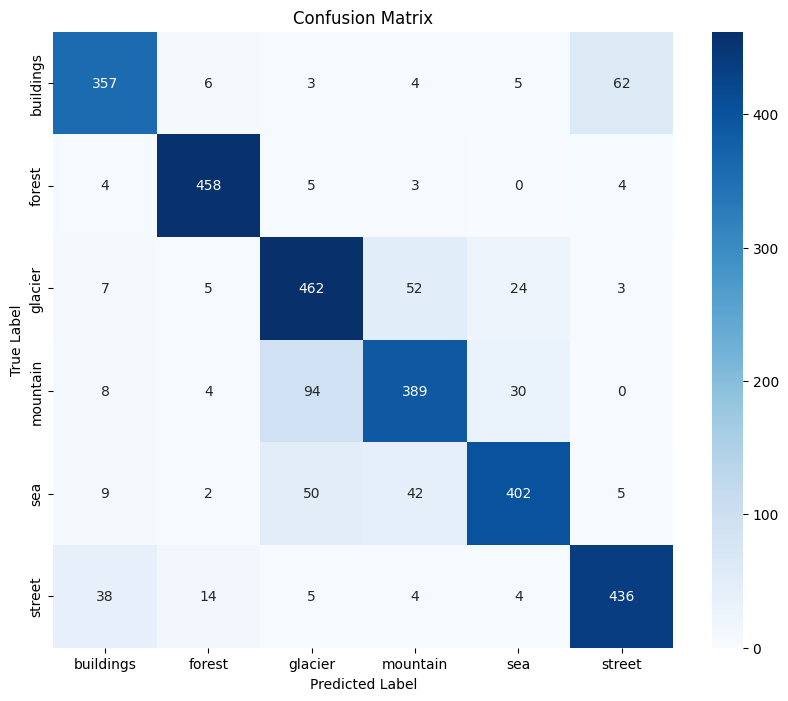

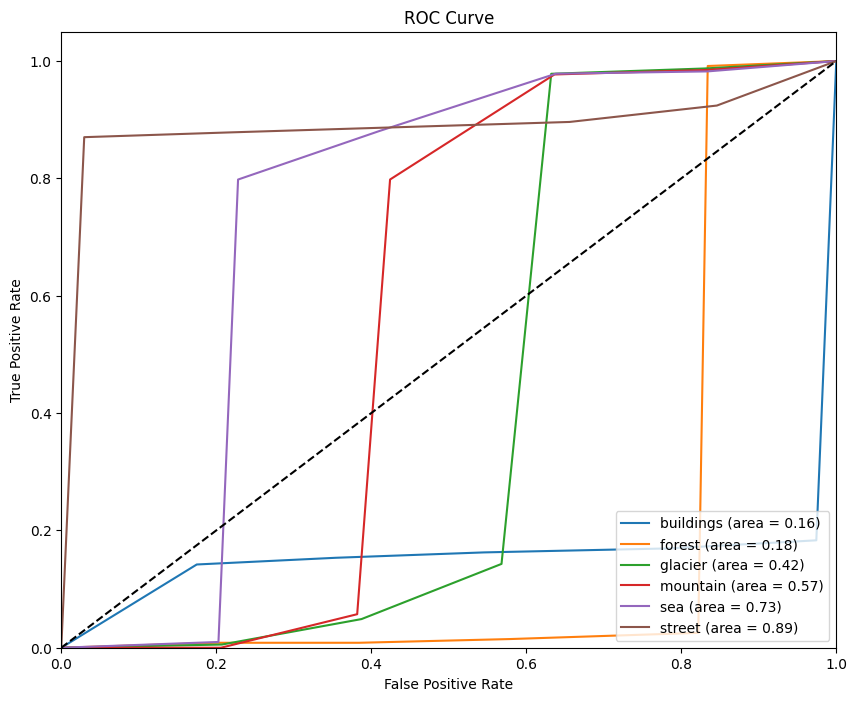

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            # Move inputs and labels to the same device as the model
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return all_labels, all_preds

# Calculate metrics function
def calculate_metrics(labels, preds):
    accuracy = np.mean(np.array(labels) == np.array(preds))
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

labels, preds = evaluate_model(model, test_loader)
accuracy, precision, recall, f1 = calculate_metrics(labels, preds)
logging.info(f'Evaluation metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(labels, preds, train_dataset.dataset.classes)

def plot_roc_curve(labels, preds, classes):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(labels, preds, pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(labels, preds, train_dataset.dataset.classes)

## 8. Hyperparameter Tuning

In [11]:
# Hyperparameter tuning with Optuna
logging.info('Starting hyperparameter tuning with Optuna')
def hyperparameters_tuning(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 64)

    # Create data loaders with the suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Initialize model, loss function, and optimizer with the suggested learning rate
    model = CustomCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)
    val_loss = val_losses[-1]

    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(hyperparameters_tuning, n_trials=10)
logging.info(f'Best hyperparameters: {study.best_params}')

[I 2024-08-13 14:38:17,719] A new study created in memory with name: no-name-93f7d503-4b77-4957-97ae-af6f6b596775


Epoch 1/5, Train Loss: 1.2106, Val Loss: 0.9414
Epoch 2/5, Train Loss: 0.9021, Val Loss: 0.7432
Epoch 3/5, Train Loss: 0.7420, Val Loss: 0.6459
Epoch 4/5, Train Loss: 0.6544, Val Loss: 0.5955
Epoch 5/5, Train Loss: 0.5937, Val Loss: 0.5438


[I 2024-08-13 14:40:51,186] Trial 0 finished with value: 0.5437792343528647 and parameters: {'lr': 0.0001016360141832646, 'batch_size': 37}. Best is trial 0 with value: 0.5437792343528647.


Epoch 1/5, Train Loss: 1.1672, Val Loss: 0.8840
Epoch 2/5, Train Loss: 0.8443, Val Loss: 0.6830
Epoch 3/5, Train Loss: 0.6833, Val Loss: 0.5961
Epoch 4/5, Train Loss: 0.6065, Val Loss: 0.5308
Epoch 5/5, Train Loss: 0.5422, Val Loss: 0.4969


[I 2024-08-13 14:43:25,371] Trial 1 finished with value: 0.4969480641312518 and parameters: {'lr': 0.00025396709062017447, 'batch_size': 48}. Best is trial 1 with value: 0.4969480641312518.


Epoch 1/5, Train Loss: 1.1180, Val Loss: 0.8683
Epoch 2/5, Train Loss: 0.7815, Val Loss: 0.6046
Epoch 3/5, Train Loss: 0.6417, Val Loss: 0.5063
Epoch 4/5, Train Loss: 0.5639, Val Loss: 0.4997
Epoch 5/5, Train Loss: 0.5092, Val Loss: 0.4594


[I 2024-08-13 14:45:59,354] Trial 2 finished with value: 0.45944985607638955 and parameters: {'lr': 0.00040664102190888016, 'batch_size': 16}. Best is trial 2 with value: 0.45944985607638955.


Epoch 1/5, Train Loss: 1.1553, Val Loss: 0.8937
Epoch 2/5, Train Loss: 0.8239, Val Loss: 0.7168
Epoch 3/5, Train Loss: 0.6747, Val Loss: 0.5630
Epoch 4/5, Train Loss: 0.5858, Val Loss: 0.5222
Epoch 5/5, Train Loss: 0.5216, Val Loss: 0.4800


[I 2024-08-13 14:48:32,784] Trial 3 finished with value: 0.4799846582849261 and parameters: {'lr': 0.00035769420591141285, 'batch_size': 40}. Best is trial 2 with value: 0.45944985607638955.


Epoch 1/5, Train Loss: 1.1761, Val Loss: 0.8972
Epoch 2/5, Train Loss: 0.8749, Val Loss: 0.7350
Epoch 3/5, Train Loss: 0.7130, Val Loss: 0.5789
Epoch 4/5, Train Loss: 0.6109, Val Loss: 0.5482
Epoch 5/5, Train Loss: 0.5633, Val Loss: 0.5403


[I 2024-08-13 14:51:06,754] Trial 4 finished with value: 0.5402606097427575 and parameters: {'lr': 8.774763711551867e-05, 'batch_size': 19}. Best is trial 2 with value: 0.45944985607638955.


Epoch 1/5, Train Loss: 1.3028, Val Loss: 1.0156
Epoch 2/5, Train Loss: 1.0486, Val Loss: 0.9320
Epoch 3/5, Train Loss: 0.9610, Val Loss: 0.8431
Epoch 4/5, Train Loss: 0.8736, Val Loss: 0.7515
Epoch 5/5, Train Loss: 0.8166, Val Loss: 0.7502


[I 2024-08-13 14:53:41,044] Trial 5 finished with value: 0.7502294601974907 and parameters: {'lr': 2.732211119288506e-05, 'batch_size': 31}. Best is trial 2 with value: 0.45944985607638955.


Epoch 1/5, Train Loss: 1.4504, Val Loss: 1.1540
Epoch 2/5, Train Loss: 1.1728, Val Loss: 1.0474
Epoch 3/5, Train Loss: 1.0588, Val Loss: 0.9588
Epoch 4/5, Train Loss: 0.9922, Val Loss: 0.9318
Epoch 5/5, Train Loss: 0.9418, Val Loss: 0.8498


[I 2024-08-13 14:56:14,690] Trial 6 finished with value: 0.8498323875315049 and parameters: {'lr': 1.6912102159025983e-05, 'batch_size': 56}. Best is trial 2 with value: 0.45944985607638955.


Epoch 1/5, Train Loss: 1.4085, Val Loss: 1.1196
Epoch 2/5, Train Loss: 1.1489, Val Loss: 1.0244
Epoch 3/5, Train Loss: 1.0544, Val Loss: 0.9689
Epoch 4/5, Train Loss: 1.0063, Val Loss: 0.9094
Epoch 5/5, Train Loss: 0.9444, Val Loss: 0.8574


[I 2024-08-13 14:58:47,538] Trial 7 finished with value: 0.8573743373983436 and parameters: {'lr': 1.481975637011249e-05, 'batch_size': 39}. Best is trial 2 with value: 0.45944985607638955.


Epoch 1/5, Train Loss: 1.3483, Val Loss: 1.1141
Epoch 2/5, Train Loss: 1.0736, Val Loss: 1.0417
Epoch 3/5, Train Loss: 0.9719, Val Loss: 0.8598
Epoch 4/5, Train Loss: 0.9048, Val Loss: 0.8239
Epoch 5/5, Train Loss: 0.8496, Val Loss: 0.7773


[I 2024-08-13 15:01:21,062] Trial 8 finished with value: 0.7772947537402312 and parameters: {'lr': 3.5051364335802406e-05, 'batch_size': 59}. Best is trial 2 with value: 0.45944985607638955.


Epoch 1/5, Train Loss: 1.3500, Val Loss: 1.0703
Epoch 2/5, Train Loss: 1.0883, Val Loss: 0.9683
Epoch 3/5, Train Loss: 1.0132, Val Loss: 0.8901
Epoch 4/5, Train Loss: 0.9363, Val Loss: 0.8403
Epoch 5/5, Train Loss: 0.8642, Val Loss: 0.7778


[I 2024-08-13 15:03:53,786] Trial 9 finished with value: 0.7778121375224807 and parameters: {'lr': 1.9186778118043217e-05, 'batch_size': 32}. Best is trial 2 with value: 0.45944985607638955.


## 9. Retraining Model with Best Hyperparameters

In [12]:
best_parameters = study.best_params
lr = best_parameters['lr']
batch_size = best_parameters['batch_size']

# Create data loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Initialize model, loss function, and optimizer with the best learning rate
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Retrain the model with the best hyperparameters
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Load the best model
model.load_state_dict(torch.load(f'best_{model.__class__.__name__}.pth'))
logging.info('Best model loaded after hyperparameter tuning')

Epoch 1/10, Train Loss: 1.1395, Val Loss: 0.8873
Epoch 2/10, Train Loss: 0.8024, Val Loss: 0.6193
Epoch 3/10, Train Loss: 0.6552, Val Loss: 0.5478
Epoch 4/10, Train Loss: 0.5633, Val Loss: 0.5152
Epoch 5/10, Train Loss: 0.5210, Val Loss: 0.5147
Epoch 6/10, Train Loss: 0.4657, Val Loss: 0.4401
Epoch 7/10, Train Loss: 0.4349, Val Loss: 0.4571
Epoch 8/10, Train Loss: 0.4054, Val Loss: 0.3981
Epoch 9/10, Train Loss: 0.3770, Val Loss: 0.4131
Epoch 10/10, Train Loss: 0.3410, Val Loss: 0.4087


## 10. Final Model Evaluation (on the Test dataset)

Final Accuracy: 0.8600, Precision: 0.8633, Recall: 0.8600, F1 Score: 0.8602


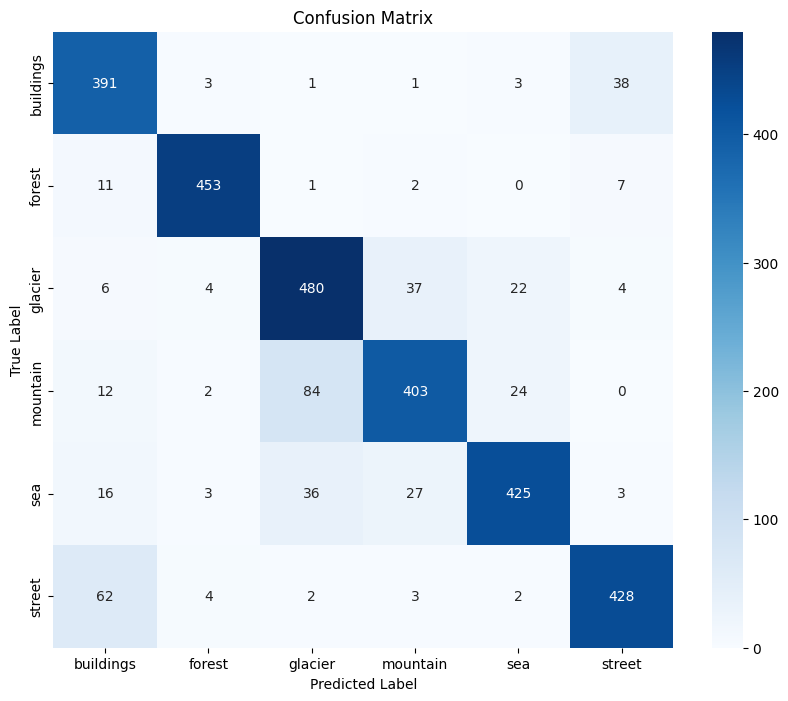

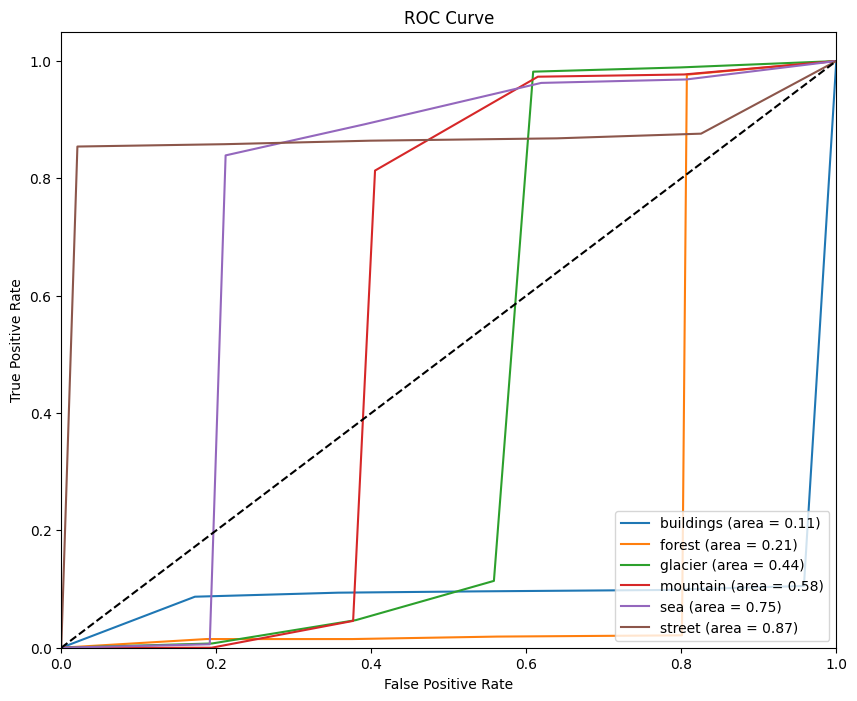

In [13]:
# Final evaluation on the test set
labels, predictions = evaluate_model(model, test_loader)
accuracy, precision, recall, f1 = calculate_metrics(labels, predictions)
logging.info(f'Final evaluation metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
print(f'Final Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

plot_confusion_matrix(labels, preds, train_dataset.dataset.classes)

plot_roc_curve(labels, preds, train_dataset.dataset.classes)


## 11. Visualization of Results

We will visualize the class activation maps (CAM) to understand the model's performance and decision-making process.


<ipython-input-14-d357ab6e9540>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)


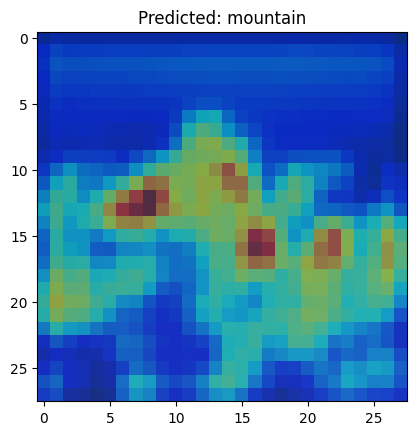

In [14]:
def visualize_cam(model, image_path, transform):
    model.eval()
    response = requests.get(image_path)
    img = Image.open(BytesIO(response.content))
    input_tensor = transform(img).unsqueeze(0).to(next(model.parameters()).device)
    features_blobs = []

    # Hook into the final convolutional layer (Conv2d layer at index 9)
    def hook_feature(module, input, output):
        features_blobs.append(output.cpu().data.numpy())  # Move to CPU and convert to numpy

    # Hooking into the layer at index 9
    model.features[9].register_forward_hook(hook_feature)

    output = model(input_tensor)
    _, pred = torch.max(output, 1)

    # Move the weights to CPU before converting to numpy
    weights = list(model.classifier[6].parameters())[0].cpu().data.numpy()

    cam = np.zeros(features_blobs[0].shape[2:], dtype=np.float32)
    for i, w in enumerate(weights[pred]):
        cam += w * features_blobs[0][0, i, :, :]
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = np.uint8(cam * 255)
    img = img.resize((224, 224), Image.ANTIALIAS)
    img = np.array(img)
    plt.imshow(img)
    plt.imshow(cam, alpha=0.5, cmap='jet')
    plt.title(f'Predicted: {train_dataset.dataset.classes[pred]}')
    plt.show()

# Example usage of CAM visualization
sample_image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRhba4ZBu8B9lAB36S-o9QZJoD9C5o9Qq_wlQ&s'
visualize_cam(model, sample_image_url, transform_test)
logging.info('CAM visualization completed')


## 12. Model Saving and Loading

We will implement functionality to save and load the entire model architecture and weights.


In [15]:
# Save model state_dict
torch.save(model.state_dict(), 'model_state_dict.pth')
logging.info('Model state_dict saved')

# Load model state_dict
model.load_state_dict(torch.load('model_state_dict.pth'))
logging.info('Model state_dict loaded')

## 13. Conclusion

### Summary of Model Performance

Overall, the CNN model performed really well in classifying images into the six categories we were targeting. With 10 epochs, we saw a steady drop in both training and validation losses, indicating that the model was learning effectively. By the end of the initial training, the model reached a training loss of 0.4743 and a validation loss of 0.4894. However, we noticed a slight increase in the validation loss towards the end, which might indicate the model was starting to overfit.

### Hyperparameter Tuning and Its Impact

To further enhance the model's performance, we performed hyperparameter tuning, which involved optimizing parameters such as the learning rate and batch size. This process led to a significant improvement in the model's overall accuracy and generalization ability. After tuning, the model not only showed a reduced validation loss but also demonstrated better performance across key metrics, confirming the effectiveness of the tuning process.

### Performance Metrics

After hyperparameter tuning, the model's performance improved as reflected in the following metrics:

- **Accuracy**: 86.00% (an increase from the initial 83.47%)
- **Precision**: 86.33% (an increase from the initial 83.60%)
- **Recall**: 86.00% (an increase from the initial 83.47%)
- **F1 Score**: 86.02% (an increase from the initial 83.44%)

These metrics indicate that the model became more accurate and balanced in its predictions. The increase in accuracy, coupled with the high precision and recall, suggests that the hyperparameter tuning helped the model make more consistent and reliable decisions, reducing errors and improving overall classification performance.

### Recommendations for Improvement

Even though the model performed well, there’s always room for improvement. Here are some ideas:

1. **Early Stopping**
- Why?: To avoid overfitting, we could stop training when the validation loss stops improving.
- How?: We can set up early stopping to monitor validation loss and halt training if it starts to increase.
2. **Learning Rate Scheduling**
- Why?: Adjusting the learning rate as training progresses can help the model fine-tune its learning process.
- How?: Use a learning rate scheduler to gradually reduce the learning rate when the model's improvement slows down.
3. **Data Augmentation**
- Why?: Adding more variety to the training data can help the model generalize better to new, unseen data.
- How?: Apply techniques like flipping, rotating, or changing the colors of the training images to create more examples.
4. **Regularization Techniques**
- Why?: Regularization helps the model avoid becoming too complex and overfitting the training data.
- How?: Increase dropout rates or add L2 regularization to the model's layers to simplify the learning process.
5. **Model Architecture Tuning**
- Why?: Tweaking the model’s structure, like changing the number of filters or layers, could help it better capture the complexities of the data.
- How?: Experiment with deeper networks, more layers, or adding batch normalization.
6. **Ensemble Methods**
- Why?: Combining multiple models can smooth out errors and lead to better overall predictions.
- How?: Train several models with different setups and combine their predictions through averaging or voting.
7. **Class Weight Adjustment**
- Why?: If some classes are harder to predict because they have fewer examples, giving them more weight can help the model pay more attention to them.
- How?: Adjust the class weights in the loss function to give more importance to underrepresented classes.

In my view, the CNN model has done a commendable job with this task, especially after hyperparameter tuning, which significantly enhanced its accuracy and overall performance. By implementing some of the above suggestions, we could push its performance even further. This might involve a bit of trial and error, but it’s worth it to get the most out of the model and make it even more robust and reliable for real-world use.